# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Others
import shutil
import random

# Load dataset

In [4]:
# Download dataset
od.download('https://www.kaggle.com/datasets/ahmadhabibhasanzein/apple-data')

Skipping, found downloaded files in "./apple-data" (use force=True to force download)


In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/train",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/valid",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 8014 files belonging to 4 classes.
==========================Validation Data====================
Found 1943 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Apple/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Apple/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 8014 images belonging to 4 classes.
Found 1943 images belonging to 4 classes.


# List Resource

In [7]:
# Check GPU
!nvidia-smi

Mon May 15 05:00:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:82:00.0 Off |                  Off |
|  0%   43C    P2    62W / 450W |  22681MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## DIY Model 1

In [6]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_DIY_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [7]:
# Define DIY Model
DIY_model = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DIY_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [8]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model = DIY_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
400/401 [============================>.] - ETA: 0s - loss: 0.6756 - accuracy: 0.7432
Epoch 1: val_accuracy improved from -inf to 0.87442, saving model to Apple_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


401/401 [==============================] - 22s 46ms/step - loss: 0.6749 - accuracy: 0.7434 - val_loss: 0.3113 - val_accuracy: 0.8744 - lr: 0.0010
Epoch 2/100
400/401 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.9048
Epoch 2: val_accuracy improved from 0.87442 to 0.94853, saving model to Apple_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


401/401 [==============================] - 19s 47ms/step - loss: 0.2697 - accuracy: 0.9048 - val_loss: 0.1404 - val_accuracy: 0.9485 - lr: 0.0010
Epoch 3/100
400/401 [============================>.] - ETA: 0s - loss: 0.1946 - accuracy: 0.9313
Epoch 3: val_accuracy did not improve from 0.94853
401/401 [==============================] - 16s 39ms/step - loss: 0.1946 - accuracy: 0.9312 - val_loss: 0.1503 - val_accuracy: 0.9480 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.9460
Epoch 4: val_accuracy improved from 0.94853 to 0.96037, saving model to Apple_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


401/401 [==============================] - 18s 45ms/step - loss: 0.1515 - accuracy: 0.9460 - val_loss: 0.1135 - val_accuracy: 0.9604 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.1030 - accuracy: 0.9622
Epoch 5: val_accuracy did not improve from 0.96037
401/401 [==============================] - 16s 39ms/step - loss: 0.1030 - accuracy: 0.9622 - val_loss: 0.1873 - val_accuracy: 0.9377 - lr: 0.0010
Epoch 6/100
401/401 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9713
Epoch 6: val_accuracy did not improve from 0.96037
401/401 [==============================] - 16s 39ms/step - loss: 0.0792 - accuracy: 0.9713 - val_loss: 0.1121 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 7/100
400/401 [============================>.] - ETA: 0s - loss: 0.0713 - accuracy: 0.9765
Epoch 7: val_accuracy improved from 0.96037 to 0.96243, saving model to Apple_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


401/401 [==============================] - 19s 47ms/step - loss: 0.0711 - accuracy: 0.9765 - val_loss: 0.1257 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 8/100
400/401 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9775
Epoch 8: val_accuracy did not improve from 0.96243
401/401 [==============================] - 16s 40ms/step - loss: 0.0645 - accuracy: 0.9774 - val_loss: 0.1972 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 9/100
400/401 [============================>.] - ETA: 0s - loss: 0.0436 - accuracy: 0.9852
Epoch 9: val_accuracy did not improve from 0.96243
401/401 [==============================] - 16s 40ms/step - loss: 0.0442 - accuracy: 0.9852 - val_loss: 0.1456 - val_accuracy: 0.9593 - lr: 0.0010
Epoch 10/100
401/401 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9780
Epoch 10: val_accuracy did not improve from 0.96243
401/401 [==============================] - 16s 40ms/step - loss: 0.0618 - accuracy: 0.9780 - val_loss: 0.1497 - val_

INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


401/401 [==============================] - 19s 48ms/step - loss: 0.0175 - accuracy: 0.9939 - val_loss: 0.1343 - val_accuracy: 0.9645 - lr: 1.0000e-04
Epoch 13/100
401/401 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9995
Epoch 13: val_accuracy improved from 0.96449 to 0.96706, saving model to Apple_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


401/401 [==============================] - 20s 50ms/step - loss: 0.0043 - accuracy: 0.9995 - val_loss: 0.1273 - val_accuracy: 0.9671 - lr: 1.0000e-04
Epoch 14/100
400/401 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9991
Epoch 14: val_accuracy did not improve from 0.96706
401/401 [==============================] - 16s 40ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.1270 - val_accuracy: 0.9660 - lr: 1.0000e-04
Epoch 15/100
401/401 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9989
Epoch 15: val_accuracy improved from 0.96706 to 0.96861, saving model to Apple_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


401/401 [==============================] - 20s 49ms/step - loss: 0.0028 - accuracy: 0.9989 - val_loss: 0.1266 - val_accuracy: 0.9686 - lr: 1.0000e-04
Epoch 16/100
401/401 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9993
Epoch 16: val_accuracy improved from 0.96861 to 0.96963, saving model to Apple_DIY_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model1_Based_Non_Augmented\assets



Epoch 16: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
401/401 [==============================] - 20s 49ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.1253 - val_accuracy: 0.9696 - lr: 1.0000e-04
Epoch 17/100
401/401 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9999
Epoch 17: val_accuracy did not improve from 0.96963
401/401 [==============================] - 16s 40ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.1241 - val_accuracy: 0.9696 - lr: 1.0000e-05
Epoch 18/100
401/401 [==============================] - ETA: 0s - loss: 7.9263e-04 - accuracy: 1.0000
Epoch 18: val_accuracy did not improve from 0.96963
401/401 [==============================] - 16s 41ms/step - loss: 7.9263e-04 - accuracy: 1.0000 - val_loss: 0.1253 - val_accuracy: 0.9691 - lr: 1.0000e-05
Epoch 19/100
400/401 [============================>.] - ETA: 0s - loss: 8.1615e-04 - accuracy: 0.9999
Epoch 19: val_accuracy did not improve from 0.96963
401/401 [

Text(0.5, 1.0, 'Training and validation loss DIY Model')

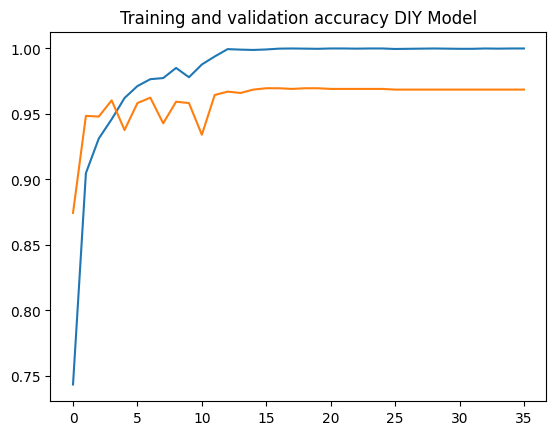

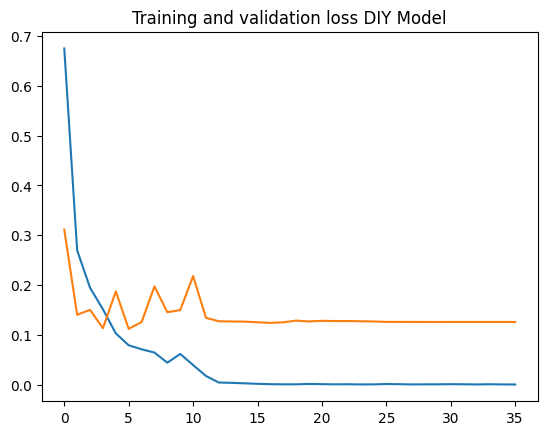

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model.history['accuracy' ]
val_acc  = history_DIY_model.history['val_accuracy' ]
loss     = history_DIY_model.history['loss' ]
val_loss = history_DIY_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')

## DIY Model 2

In [10]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_DIY_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [11]:
# Define DIY Model
DIY_model_2 = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
DIY_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [12]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model_2 = DIY_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
400/401 [============================>.] - ETA: 0s - loss: 0.6063 - accuracy: 0.7802
Epoch 1: val_accuracy improved from -inf to 0.88111, saving model to Apple_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


401/401 [==============================] - 22s 53ms/step - loss: 0.6055 - accuracy: 0.7806 - val_loss: 0.3486 - val_accuracy: 0.8811 - lr: 0.0010
Epoch 2/100
400/401 [============================>.] - ETA: 0s - loss: 0.2864 - accuracy: 0.9008
Epoch 2: val_accuracy improved from 0.88111 to 0.89295, saving model to Apple_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


401/401 [==============================] - 24s 61ms/step - loss: 0.2858 - accuracy: 0.9010 - val_loss: 0.3369 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.9334
Epoch 3: val_accuracy improved from 0.89295 to 0.94390, saving model to Apple_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


401/401 [==============================] - 24s 60ms/step - loss: 0.1837 - accuracy: 0.9334 - val_loss: 0.1497 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9516
Epoch 4: val_accuracy improved from 0.94390 to 0.95368, saving model to Apple_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


401/401 [==============================] - 25s 63ms/step - loss: 0.1406 - accuracy: 0.9516 - val_loss: 0.1337 - val_accuracy: 0.9537 - lr: 0.0010
Epoch 5/100
400/401 [============================>.] - ETA: 0s - loss: 0.1109 - accuracy: 0.9633
Epoch 5: val_accuracy improved from 0.95368 to 0.96037, saving model to Apple_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


401/401 [==============================] - 25s 62ms/step - loss: 0.1107 - accuracy: 0.9634 - val_loss: 0.1317 - val_accuracy: 0.9604 - lr: 0.0010
Epoch 6/100
400/401 [============================>.] - ETA: 0s - loss: 0.0903 - accuracy: 0.9706
Epoch 6: val_accuracy did not improve from 0.96037
401/401 [==============================] - 19s 46ms/step - loss: 0.0902 - accuracy: 0.9707 - val_loss: 0.2055 - val_accuracy: 0.9233 - lr: 0.0010
Epoch 7/100
401/401 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9813
Epoch 7: val_accuracy did not improve from 0.96037
401/401 [==============================] - 18s 46ms/step - loss: 0.0671 - accuracy: 0.9813 - val_loss: 0.2061 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 8/100
400/401 [============================>.] - ETA: 0s - loss: 0.0819 - accuracy: 0.9727
Epoch 8: val_accuracy did not improve from 0.96037
401/401 [==============================] - 18s 45ms/step - loss: 0.0818 - accuracy: 0.9728 - val_loss: 0.1954 - val_ac

INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


401/401 [==============================] - 26s 64ms/step - loss: 0.0516 - accuracy: 0.9840 - val_loss: 0.1251 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 11/100
401/401 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9888
Epoch 11: val_accuracy improved from 0.96449 to 0.96758, saving model to Apple_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


401/401 [==============================] - 25s 62ms/step - loss: 0.0400 - accuracy: 0.9888 - val_loss: 0.1201 - val_accuracy: 0.9676 - lr: 0.0010
Epoch 12/100
401/401 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9900
Epoch 12: val_accuracy improved from 0.96758 to 0.97633, saving model to Apple_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


401/401 [==============================] - 26s 65ms/step - loss: 0.0310 - accuracy: 0.9900 - val_loss: 0.1167 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 13/100
400/401 [============================>.] - ETA: 0s - loss: 2.6816e-04 - accuracy: 1.0000
Epoch 13: val_accuracy improved from 0.97633 to 0.97890, saving model to Apple_DIY_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_DIY_model2_Based_Non_Augmented\assets


401/401 [==============================] - 26s 66ms/step - loss: 2.6749e-04 - accuracy: 1.0000 - val_loss: 0.1356 - val_accuracy: 0.9789 - lr: 0.0010
Epoch 14/100
400/401 [============================>.] - ETA: 0s - loss: 2.5515e-05 - accuracy: 1.0000
Epoch 14: val_accuracy did not improve from 0.97890
401/401 [==============================] - 18s 45ms/step - loss: 2.5455e-05 - accuracy: 1.0000 - val_loss: 0.1449 - val_accuracy: 0.9774 - lr: 0.0010
Epoch 15/100
400/401 [============================>.] - ETA: 0s - loss: 1.2967e-05 - accuracy: 1.0000
Epoch 15: val_accuracy did not improve from 0.97890
401/401 [==============================] - 18s 45ms/step - loss: 1.2954e-05 - accuracy: 1.0000 - val_loss: 0.1537 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 16/100
400/401 [============================>.] - ETA: 0s - loss: 7.6721e-06 - accuracy: 1.0000
Epoch 16: val_accuracy did not improve from 0.97890
401/401 [==============================] - 18s 45ms/step - loss: 7.7062e-06 - accuracy: 

Text(0.5, 1.0, 'Training and validation loss DIY Model')

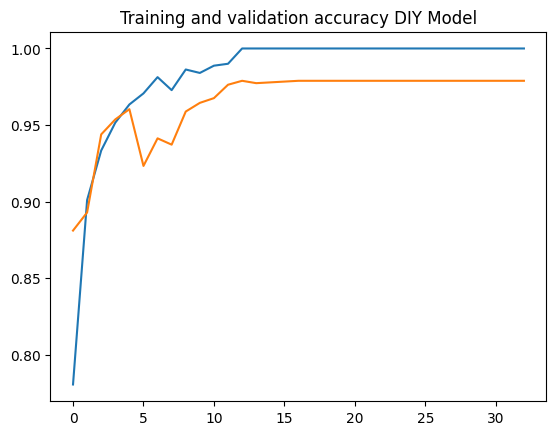

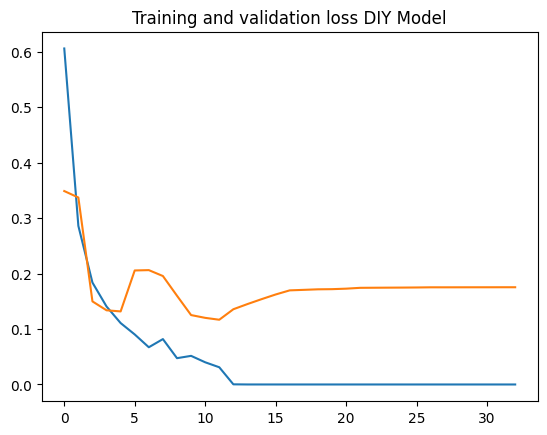

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model_2.history['accuracy' ]
val_acc  = history_DIY_model_2.history['val_accuracy' ]
loss     = history_DIY_model_2.history['loss' ]
val_loss = history_DIY_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')